# Imports

In [65]:
import re
import string
from collections import Counter
from typing import List
from collections import defaultdict
import joblib

from sklearn.datasets import fetch_20newsgroups
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import f1_score
import matplotlib.pyplot as plt
import numpy as np
import nltk
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from tqdm import tqdm

In [2]:
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')

[nltk_data] Downloading package punkt to
[nltk_data]     /Users/rafaelkadyrov/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/rafaelkadyrov/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/rafaelkadyrov/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

# Constants

In [3]:
RANDOM_SEED = 42
STOP_WORDS = nltk.corpus.stopwords.words("english")

# Functions

In [4]:
def plot_classes_distribution(labels_array: np.ndarray):
    classes, counts = np.unique(train_val_y, return_counts=True)
    
    plt.figure(figsize=(8, 6))
    plt.bar(classes, counts, color='skyblue')
    plt.title('Classes distribution')
    plt.xlabel('Class name')
    plt.ylabel('Counts')
    plt.xticks(classes)
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.tight_layout()
    plt.show()

In [5]:
lemmatizer = nltk.stem.WordNetLemmatizer()

def preprocess_single_text(text: str) -> str:
    text = text.lower()    
    text = re.sub(r"http\S+|www\S+|https\S+", '', text, flags=re.MULTILINE) # Remove web links
    text = re.sub(r'\d+', '', text) # Remove numbers
    text = re.sub(r'\b[\w.-]+?@\w+?\.\w+?\b', '', text) # Remove emails
    text = text.translate(str.maketrans('', '', string.punctuation + "«»–…"))
    tokens = nltk.word_tokenize(text)
    tokens = [lemmatizer.lemmatize(word) for word in tokens if word not in STOP_WORDS]
    return ' '.join(tokens)

In [6]:
def preprocess_corpus(corpus: List[str])->List[str]:
    return [preprocess_single_text(text) for text in corpus]

In [7]:
def simple_tokenizer(text):
    return text.lower().split()

In [8]:
def build_vocab(texts, min_freq=1):
    counter = Counter()
    for text in texts:
        tokens = simple_tokenizer(text)
        counter.update(tokens)
    vocab = {"<pad>": 0, "<unk>": 1}
    for word, freq in counter.items():
        if freq >= min_freq:
            vocab[word] = len(vocab)
    return vocab

# Data Preparation

In [9]:
train_val_split = fetch_20newsgroups(subset="train",
                                     data_home="../data/",
                                     remove=('headers', 'footers', 'quotes'),
                                     shuffle=False
                                    )
test_split = fetch_20newsgroups(subset="test",
                                data_home="../data/",
                                shuffle=False)
train_val_x, train_val_y = train_val_split.data, train_val_split.target
test_x, test_y = test_split.data, test_split.target

NUM_CLASSES = len(train_val_split.target_names)

In [10]:
train_x, val_x, train_y, val_y = train_test_split(train_val_x, train_val_y,
                                                  test_size=0.25,
                                                  random_state=RANDOM_SEED, stratify=train_val_y)

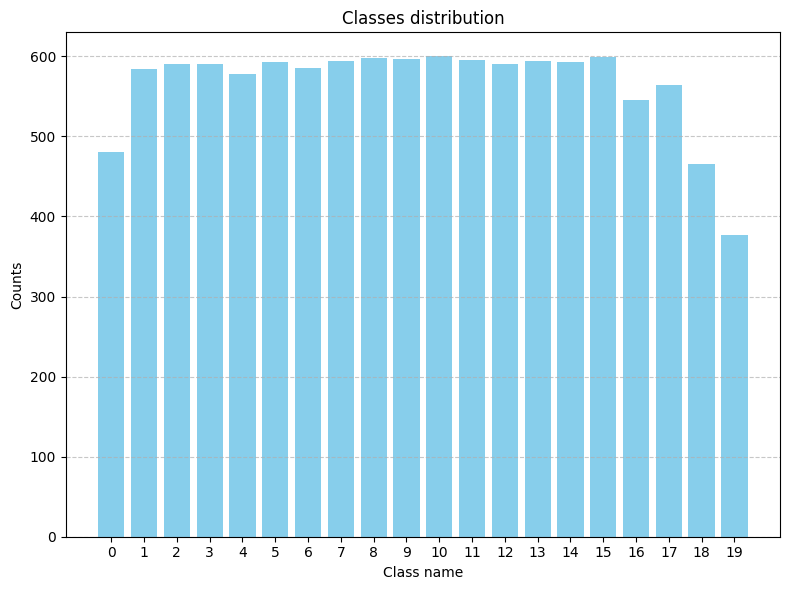

In [11]:
plot_classes_distribution(train_y)

# Model training

## Training simple model using sklearn

In [60]:
text_clf = Pipeline([
    ('vectorizer', TfidfVectorizer(preprocessor=preprocess_single_text)),
    ('classifier', MultinomialNB(alpha=.01))
])
text_clf.fit(train_x, train_y)

,steps,"[('vectorizer', ...), ('classifier', ...)]"
,transform_input,None
,memory,None
,verbose,False
,input,'content'
,encoding,'utf-8'
,decode_error,'strict'
,strip_accents,None
,lowercase,True
,preprocessor,<function pre...t 0x1196af240>
,tokenizer,None


In [61]:
f1_score(val_y, text_clf.predict(val_x), average="macro")

0.7459835495161714

## Training Pytorch FCN-based model with TF-IDF features

In [68]:
# feature_extractor = TfidfVectorizer(preprocessor=preprocess_single_text)
feature_extractor = TfidfVectorizer(stop_words='english', use_idf=True)
joblib.dump(feature_extractor, "../models/tfidf_vectorizer.pkl")

train_x_vectorized = feature_extractor.fit_transform(train_x).toarray()
val_x_vectorized = feature_extractor.transform(val_x).toarray()

In [69]:
train_x_vectorized.shape

(8485, 32273)

In [70]:
class TfidfDataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.tensor(X, dtype=torch.float32)
        self.y = torch.tensor(y, dtype=torch.long)

    def __len__(self):
        return len(self.y)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

In [71]:
train_dataset = TfidfDataset(train_x_vectorized, train_y)
train_loader = DataLoader(train_dataset)

val_dataset = TfidfDataset(val_x_vectorized, val_y)
val_loader = DataLoader(val_dataset)

In [72]:
train_x_vectorized.shape

(8485, 32273)

In [73]:
class FFNN(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super().__init__()
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        return self.fc2(self.relu(self.fc1(x)))

In [74]:
EPOCHS_NUM = 20

In [78]:
if torch.cuda.is_available():
    device = torch.device("cuda")
elif torch.backends.mps.is_available():
    device = torch.device("mps")
else:
    device = torch.device("cpu")

model_config = {
    "input_dim": train_x_vectorized.shape[1],
    "hidden_dim": 128,
    "output_dim": NUM_CLASSES
}

model = FFNN(**model_config)
model = model.to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.0003, weight_decay=0.0005)

history = defaultdict(list)

min_val_loss = float("inf")

for epoch in range(EPOCHS_NUM):
    print(f"Epoch {epoch}/{EPOCHS_NUM - 1}")
    model.train()
    running_loss = 0.0
    for inputs, labels in tqdm(train_loader, desc="Training"):
        inputs = inputs.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()
        outputs = model(inputs)
        loss_value = criterion(outputs, labels)
        _, preds = torch.max(outputs, 1)
        loss_value.backward()
        optimizer.step()
        
        running_loss += loss_value.item() * inputs.size(0)
        
    model.eval()
    running_corrects = 0
    val_running_loss = 0.0
    TP = torch.zeros(NUM_CLASSES)
    FP = torch.zeros(NUM_CLASSES)
    FN = torch.zeros(NUM_CLASSES)
    
    for inputs, labels in tqdm(val_loader, desc="Validating"):
        inputs = inputs.to(device)
        labels = labels.to(device)

        with torch.no_grad():
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
        loss_value = criterion(outputs, labels)
        preds = preds.cpu()
        labels = labels.cpu()
        for cls in range(NUM_CLASSES):
            TP[cls] += ((preds == cls) & (labels == cls)).sum()
            FP[cls] += ((preds == cls) & (labels != cls)).sum()
            FN[cls] += ((preds != cls) & (labels == cls)).sum()
        running_corrects += torch.sum(preds == labels.data)
        val_running_loss += loss_value.item() * inputs.size(0)
    
    epoch_loss = running_loss / len(train_dataset)
    epoch_val_loss = val_running_loss / len(val_dataset)
    epoch_acc = running_corrects / len(val_dataset)
    epoch_precision = TP / (TP + FP + 1e-8)
    epoch_recall = TP / (TP + FN + 1e-8)
    epoch_f1 = 2 * epoch_precision * epoch_recall / (epoch_precision + epoch_recall + 1e-8)
    epoch_f1_macro = epoch_f1.mean()
    print(f"Train loss {epoch_loss:.4f}, Val loss: {epoch_val_loss:.4f}, Val accuracy: {epoch_acc.item():.4f}, Val macro f1: {epoch_f1_macro:.4f}")
    print("-"*5)
    history["train_losses"].append(epoch_loss)
    history["val_losses"].append(epoch_val_loss)
    history["val_accuracy"].append(epoch_acc)
    history["val_f1_macro"].append(epoch_f1_macro)

    if epoch_val_loss < min_val_loss:
        checkpoint = {
            'model_state_dict': model.state_dict(),
            'model_args': model_config
        }
        torch.save(checkpoint, '../models/best.pth')
        min_val_loss = epoch_val_loss
checkpoint = {
    'model_state_dict': model.state_dict(),
    'model_args': model_config
}
checkpoint.update(model_config)
torch.save(checkpoint, '../models/last.pth')

Epoch 0/19


Validating: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2829/2829 [00:05<00:00, 530.68it/s]


Train loss 2.3688, Val loss: 1.7635, Val accuracy: 0.6154, Val macro f1: 0.5729
-----
Epoch 1/19


Validating: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2829/2829 [00:04<00:00, 575.17it/s]


Train loss 1.4558, Val loss: 1.3510, Val accuracy: 0.6942, Val macro f1: 0.6737
-----
Epoch 2/19


Validating: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2829/2829 [00:04<00:00, 581.85it/s]


Train loss 1.1178, Val loss: 1.2005, Val accuracy: 0.7105, Val macro f1: 0.6888
-----
Epoch 3/19


Validating: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2829/2829 [00:04<00:00, 582.74it/s]


Train loss 0.9455, Val loss: 1.1315, Val accuracy: 0.7140, Val macro f1: 0.6927
-----
Epoch 4/19


Validating: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2829/2829 [00:05<00:00, 555.73it/s]


Train loss 0.8387, Val loss: 1.0946, Val accuracy: 0.7162, Val macro f1: 0.6983
-----
Epoch 5/19


Validating: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2829/2829 [00:05<00:00, 540.25it/s]


Train loss 0.7646, Val loss: 1.0724, Val accuracy: 0.7158, Val macro f1: 0.6979
-----
Epoch 6/19


Validating: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2829/2829 [00:05<00:00, 540.27it/s]


Train loss 0.7099, Val loss: 1.0579, Val accuracy: 0.7197, Val macro f1: 0.7052
-----
Epoch 7/19


Validating: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2829/2829 [00:05<00:00, 543.61it/s]


Train loss 0.6679, Val loss: 1.0480, Val accuracy: 0.7186, Val macro f1: 0.7065
-----
Epoch 8/19


Validating: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2829/2829 [00:04<00:00, 570.63it/s]


Train loss 0.6351, Val loss: 1.0408, Val accuracy: 0.7190, Val macro f1: 0.7084
-----
Epoch 9/19


Validating: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2829/2829 [00:05<00:00, 536.42it/s]


Train loss 0.6090, Val loss: 1.0358, Val accuracy: 0.7186, Val macro f1: 0.7090
-----
Epoch 10/19


Validating: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2829/2829 [00:05<00:00, 556.03it/s]


Train loss 0.5880, Val loss: 1.0319, Val accuracy: 0.7176, Val macro f1: 0.7082
-----
Epoch 11/19


Validating: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2829/2829 [00:05<00:00, 555.64it/s]


Train loss 0.5710, Val loss: 1.0291, Val accuracy: 0.7179, Val macro f1: 0.7094
-----
Epoch 12/19


Validating: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2829/2829 [00:05<00:00, 547.09it/s]


Train loss 0.5571, Val loss: 1.0268, Val accuracy: 0.7179, Val macro f1: 0.7099
-----
Epoch 13/19


Validating: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2829/2829 [00:04<00:00, 590.40it/s]


Train loss 0.5457, Val loss: 1.0254, Val accuracy: 0.7179, Val macro f1: 0.7105
-----
Epoch 14/19


Validating: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2829/2829 [00:05<00:00, 527.11it/s]


Train loss 0.5362, Val loss: 1.0239, Val accuracy: 0.7190, Val macro f1: 0.7113
-----
Epoch 15/19


Validating: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2829/2829 [00:05<00:00, 517.35it/s]


Train loss 0.5283, Val loss: 1.0229, Val accuracy: 0.7193, Val macro f1: 0.7121
-----
Epoch 16/19


Validating: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2829/2829 [00:05<00:00, 538.31it/s]


Train loss 0.5215, Val loss: 1.0221, Val accuracy: 0.7186, Val macro f1: 0.7117
-----
Epoch 17/19


Validating: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2829/2829 [00:05<00:00, 554.70it/s]


Train loss 0.5159, Val loss: 1.0215, Val accuracy: 0.7183, Val macro f1: 0.7113
-----
Epoch 18/19


Validating: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2829/2829 [00:05<00:00, 562.59it/s]


Train loss 0.5111, Val loss: 1.0208, Val accuracy: 0.7186, Val macro f1: 0.7117
-----
Epoch 19/19


Validating: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2829/2829 [00:05<00:00, 538.48it/s]

Train loss 0.5070, Val loss: 1.0206, Val accuracy: 0.7179, Val macro f1: 0.7110
-----


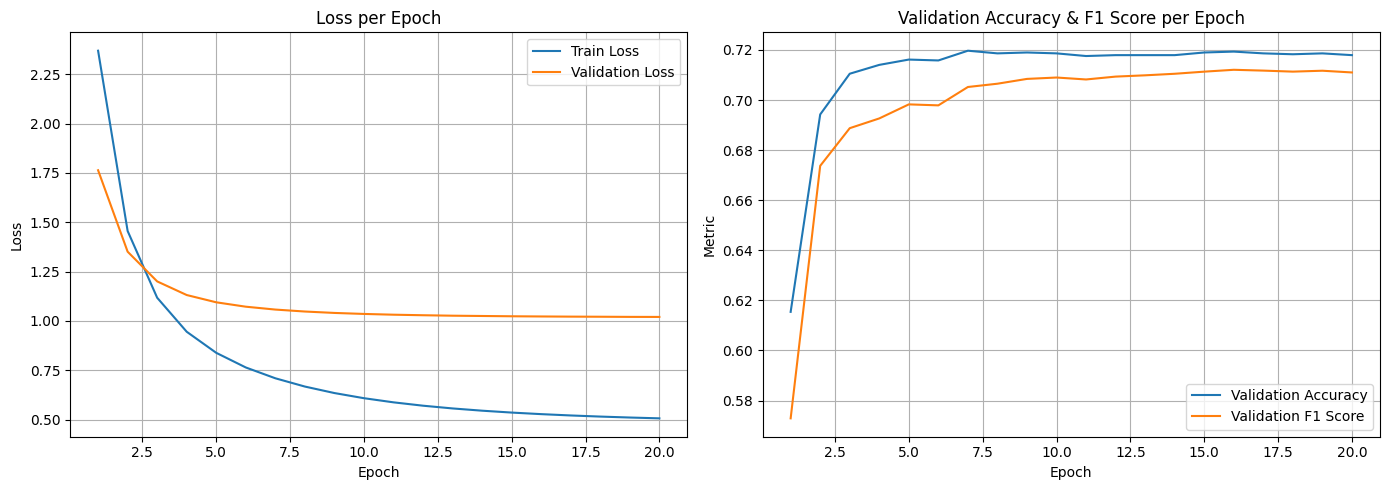

In [79]:
plt.figure(figsize=(14, 5))

epochs = range(1, len(history['train_losses']) + 1)

# График лоссов
plt.subplot(1, 2, 1)
plt.plot(epochs, history['train_losses'], label='Train Loss')
plt.plot(epochs, history['val_losses'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss per Epoch')
plt.legend()
plt.grid(True)

# График accuracy и F1
plt.subplot(1, 2, 2)
plt.plot(epochs, history['val_accuracy'], label='Validation Accuracy')
plt.plot(epochs, history['val_f1_macro'], label='Validation F1 Score')
plt.xlabel('Epoch')
plt.ylabel('Metric')
plt.title('Validation Accuracy & F1 Score per Epoch')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

In [83]:
model_checkpoint = torch.load("../models/best.pth")
model_args = model_checkpoint["model_args"]

model = FFNN(**model_args).to(device)

model.load_state_dict(model_checkpoint['model_state_dict'])

test_x_vectorized = feature_extractor.transform(test_x).toarray()
test_dataset = TfidfDataset(test_x_vectorized, test_y)
test_loader = DataLoader(test_dataset)

model.eval()
running_corrects = 0
TP = torch.zeros(NUM_CLASSES)
FP = torch.zeros(NUM_CLASSES)
FN = torch.zeros(NUM_CLASSES)

for inputs, labels in tqdm(test_loader, desc="Testing"):
    inputs = inputs.to(device)
    labels = labels.to(device)

    with torch.no_grad():
        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)
    loss_value = criterion(outputs, labels)
    preds = preds.cpu()
    labels = labels.cpu()
    for cls in range(NUM_CLASSES):
        TP[cls] += ((preds == cls) & (labels == cls)).sum()
        FP[cls] += ((preds == cls) & (labels != cls)).sum()
        FN[cls] += ((preds != cls) & (labels == cls)).sum()
    running_corrects += torch.sum(preds == labels.data)

epoch_acc = running_corrects / len(test_dataset)
epoch_precision = TP / (TP + FP + 1e-8)
epoch_recall = TP / (TP + FN + 1e-8)
epoch_f1 = 2 * epoch_precision * epoch_recall / (epoch_precision + epoch_recall + 1e-8)
epoch_f1_macro = epoch_f1.mean()
print(f"Test accuracy: {epoch_acc.item():.4f}, Test macro f1: {epoch_f1_macro:.4f}")


Testing: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7532/7532 [00:11<00:00, 641.50it/s]

Test accuracy: 0.7415, Test macro f1: 0.7345


## Training Pytorch LSTM-based model

In [155]:
preprocessed_train_x = preprocess_corpus(train_x)
preprocessed_val_x = preprocess_corpus(val_x)

In [156]:
vocab = build_vocab(preprocessed_train_x)

In [157]:
len(vocab)

67101

In [216]:
class CorpusDataset(Dataset):
    def __init__(self, texts, labels, vocab, max_len=64):
        self.texts = texts
        self.labels = labels
        self.vocab = vocab
        self.max_len = max_len

    def encode(self, text):
        tokens = simple_tokenizer(text)
        ids = [self.vocab.get(token, self.vocab["<unk>"]) for token in tokens][:self.max_len]
        ids += [self.vocab["<pad>"]] * (self.max_len - len(ids))
        return torch.tensor(ids)

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        return self.encode(self.texts[idx]), torch.tensor(self.labels[idx])

In [217]:
train_dataset = CorpusDataset(preprocessed_train_x, train_y, vocab)
val_dataset = CorpusDataset(preprocessed_val_x, val_y, vocab)

train_loader = DataLoader(train_dataset, batch_size=32)
val_loader = DataLoader(val_dataset, batch_size=32)

In [223]:
class TextClassifier(nn.Module):
    def __init__(self, vocab_size, embed_dim, hidden_dim, output_dim):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, embed_dim, padding_idx=0)
        self.lstm = nn.LSTM(embed_dim, hidden_dim, num_layers=2, batch_first=True)
        self.fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        x = self.embedding(x)
        _, (hidden, _) = self.lstm(x)
        return self.fc(hidden[-1])

In [ ]:
EPOCHS_NUM = 20

In [ ]:
if torch.cuda.is_available():
    device = torch.device("cuda")
elif torch.backends.mps.is_available():
    device = torch.device("mps")
else:
    device = torch.device("cpu")

model = TextClassifier(len(vocab), embed_dim=128, hidden_dim=128, output_dim=NUM_CLASSES)
model = model.to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

history = defaultdict(list)

for epoch in range(EPOCHS_NUM):
    print(f"Epoch {epoch}/{EPOCHS_NUM - 1}")
    model.train()
    running_loss = 0.0
    for inputs, labels in tqdm(train_loader, desc="Training"):
        inputs = inputs.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()
        outputs = model(inputs)
        loss_value = criterion(outputs, labels)
        _, preds = torch.max(outputs, 1)
        loss_value.backward()
        optimizer.step()
        
        running_loss += loss_value.item() * inputs.size(0)
        
    model.eval()
    running_corrects = 0
    val_running_loss = 0.0
    TP = torch.zeros(NUM_CLASSES)
    FP = torch.zeros(NUM_CLASSES)
    FN = torch.zeros(NUM_CLASSES)
    
    for inputs, labels in tqdm(val_loader, desc="Validating"):
        inputs = inputs.to(device)
        labels = labels.to(device)

        with torch.no_grad():
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
        loss_value = criterion(outputs, labels)
        preds = preds.cpu()
        labels = labels.cpu()
        for cls in range(NUM_CLASSES):
            TP[cls] += ((preds == cls) & (labels == cls)).sum()
            FP[cls] += ((preds == cls) & (labels != cls)).sum()
            FN[cls] += ((preds != cls) & (labels == cls)).sum()
        running_corrects += torch.sum(preds == labels.data)
        val_running_loss += loss_value.item() * inputs.size(0)
    
    epoch_loss = running_loss / len(train_dataset)
    epoch_val_loss = val_running_loss / len(val_dataset)
    epoch_acc = running_corrects / len(val_dataset)
    epoch_precision = TP / (TP + FP + 1e-8)
    epoch_recall = TP / (TP + FN + 1e-8)
    epoch_f1 = 2 * epoch_precision * epoch_recall / (epoch_precision + epoch_recall + 1e-8)
    epoch_f1_macro = epoch_f1.mean()
    print(f"Train loss {epoch_loss:.4f}, Val loss: {epoch_val_loss:.4f}, Val accuracy: {epoch_acc.item():.4f}, Val macro f1: {epoch_f1_macro:.4f}")
    print("-"*5)
    history["train_losses"].append(epoch_loss)
    history["val_losses"].append(epoch_val_loss)
    history["val_accuracy"].append(epoch_acc)
    history["val_f1_macro"].append(epoch_f1_macro)
    

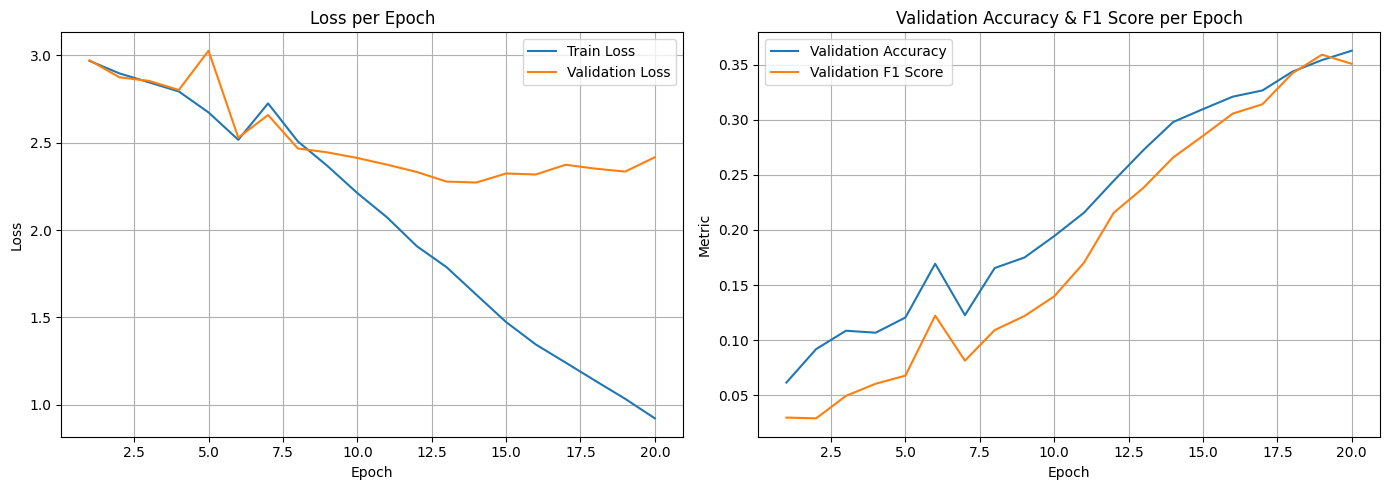

In [226]:
plt.figure(figsize=(14, 5))

epochs = range(1, len(history['train_losses']) + 1)

# График лоссов
plt.subplot(1, 2, 1)
plt.plot(epochs, history['train_losses'], label='Train Loss')
plt.plot(epochs, history['val_losses'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss per Epoch')
plt.legend()
plt.grid(True)

# График accuracy и F1
plt.subplot(1, 2, 2)
plt.plot(epochs, history['val_accuracy'], label='Validation Accuracy')
plt.plot(epochs, history['val_f1_macro'], label='Validation F1 Score')
plt.xlabel('Epoch')
plt.ylabel('Metric')
plt.title('Validation Accuracy & F1 Score per Epoch')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

In [198]:
values = []
for text in train_x:
    tokens = simple_tokenizer(text)
    values.append(len(tokens))

In [209]:
np.median(values)

np.float64(83.0)